In [1]:
# Saves a list of terms to "row_terms.txt"
# In order

In [2]:
#!/usr/bin/env python3

# import nltk
# nltk.download('wordnet')

import json
import networkx as nx
# from nltk.corpus import wordnet as wn
from transformers import AutoTokenizer

import inflect

import huggingface_hub

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

import ontology_class



The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/raymond/.cache/huggingface/token
Login successful


In [3]:
def save_ontology_hypernym(params: str, step: str, ontology_dir: str):
    # model_name = "gemma-2b"
    # tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
    model_name = "pythia"
    
    tokenizer = AutoTokenizer.from_pretrained(
        f"EleutherAI/pythia-{params}-deduped",
        revision=f"{step}",
        cache_dir=f"/mnt/bigstorage/raymond/huggingface_cache/pythia-{params}-deduped/{step}",
    )

    vocab = tokenizer.get_vocab()
    vocab_set = set(vocab.keys())
    vocab_set = set(map(lambda x: x.replace(" ", "_"), vocab_set))

    p = inflect.engine()

    def get_all_hyponym_lemmas(synset):
        hyponyms = synset.hyponyms()
        lemmas = set()
        for hyponym in hyponyms:
            lemmas.update(lemma.name() for lemma in hyponym.lemmas())
            lemmas.update(get_all_hyponym_lemmas(hyponym))  # Recursively get lemmas from hyponyms,
        
        return lemmas


    # all_noun_synsets = list(wn.all_synsets(pos=wn.NOUN))
    test = ontology_class.Onto(ontology_dir)
    all_noun_synsets = test.all_synsets()
    print(len(all_noun_synsets))
    noun_lemmas = {}
    for s in all_noun_synsets:
        lemmas = get_all_hyponym_lemmas(s)
        # add and remove space bc of how gemma vocab works
        if model_name == "gemma-2b":
            lemmas = vocab_set.intersection({"▁" + l for l in lemmas})
            # lemmas = vocab_set.intersection({l for l in lemmas})
            noun_lemmas[s.name()] = {l[1:] for l in lemmas}
        elif model_name == "pythia":
            lemmas = vocab_set.intersection({l for l in lemmas})
            noun_lemmas[s.name()] = {l for l in lemmas}
            
    # print(len(noun_lemmas))
    # for k, v in noun_lemmas.items():
    #     print(k, v)
    large_nouns = {k: v for k, v in noun_lemmas.items() if len(v) > 1}


    print(len(all_noun_synsets))
    print(len(large_nouns))


    # Construct the hypernym inclusion graph among large categories
    G_noun = nx.DiGraph()

    nodes = list(large_nouns.keys())
    for key in nodes:
        # print("key:" + key)
        # for path in wn.synset(key).hypernym_paths():
        for path in test.get_synset(key).hypernym_paths():
            # ancestors included in the cleaned set
            ancestors = [s.name() for s in path if s.name() in nodes]

            if len(ancestors) > 1:
                G_noun.add_edge(ancestors[-2],key) # first entry is itself
            else:
                print(f"no ancestors for {key}")



    # print(large_nouns)

    # if a node has only one child, and that child has only one parent, merge the two nodes
    def merge_nodes(G, lemma_dict):
        topological_sorted_nodes = list(reversed(list(nx.topological_sort(G))))

        for node in topological_sorted_nodes:
            children = list(G.successors(node))
            if len(children) == 1:
                child = children[0]
                parent_lemmas_not_in_child = lemma_dict[node] - lemma_dict[child]
                if len(list(G.predecessors(child))) == 1 or len(parent_lemmas_not_in_child) <6:
                    grandchildren = list(G.successors(child))
                    
                    if len(parent_lemmas_not_in_child) > 1:
                        if len(grandchildren) > 0:
                            lemma_dict[node + '.other'] = parent_lemmas_not_in_child
                            G.add_edge(node, node + '.other')

                    # del synset_lemmas[child]
                    for grandchild in grandchildren:
                        G.add_edge(node, grandchild)
                    G.remove_node(child)
                    print(f"merged {node} and {child}")

    # print(G_noun.nodes())
    merge_nodes(G_noun, large_nouns)
    large_nouns = {k: v for k, v in large_nouns.items() if k in G_noun.nodes()}


    G_noun = nx.DiGraph(G_noun.subgraph(nodes))


    # make a gemma specific version
    def _noun_to_gemma_vocab_elements(word):
        word = word.lower()
        plural = p.plural(word)

        add_cap_and_plural = [word, word.capitalize(), plural, plural.capitalize()]
        # add_space = ["▁" + w for w in add_cap_and_plural]
        add_space = [w for w in add_cap_and_plural]
        return vocab_set.intersection(add_space)

    ## save the data
    with open(f'data/ontologies/noun_synsets_ontology_pythia.json', 'w') as f:
        prev_pythia_words = []
        corr_synsets = []
        for synset, lemmas in large_nouns.items():
            print(G_noun.nodes())
            pythia_words = []
            for w in lemmas:
                pythia_words.extend(_noun_to_gemma_vocab_elements(w))

            if pythia_words in prev_pythia_words:
                print(f"repeated: {synset}")
            prev_pythia_words.append(pythia_words)
            corr_synsets.append(synset)

            f.write(json.dumps({synset: pythia_words}) + "\n")
            
    nx.write_adjlist(G_noun, f"data/ontologies/noun_synsets_ontology_hypernym_graph.adjlist")

In [4]:
def get_ontology_mats(params: str, step: str):
    device = torch.device("cpu")
    # tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
    tokenizer = AutoTokenizer.from_pretrained(
        f"EleutherAI/pythia-{params}-deduped",
        revision=f"{step}",
        cache_dir=f"/mnt/bigstorage/raymond/huggingface_cache/pythia-{params}-deduped/{step}",
    )

    g = torch.load(f'/mnt/bigstorage/raymond/{params}-unembeddings/{step}').to(device) # 'FILE_PATH' in store_matrices.py

    # g = torch.load('FILE_PATH').to(device)

    vocab_dict = tokenizer.get_vocab()
    new_vocab_dict = {}
    for key, value in vocab_dict.items():
        new_key = key.replace(" ", "_")
        new_vocab_dict[new_key] = value
    vocab_dict = new_vocab_dict

    vocab_list = [None] * (max(vocab_dict.values()) + 1)
    for word, index in vocab_dict.items():
        vocab_list[index] = word


    cats, G, sorted_keys = hrc.get_categories_ontology(1)
    # cats, G, sorted_keys = hrc.get_categories('noun')

    # dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in cats.items()}

    error_count = 0
    total_count = 0
    messed_up = {}
    dirs = {}
    for k, v in cats.items():
        # print(k, v)
        total_count += 1
        try:
            dirs[k] = hrc.estimate_cat_dir(v, g, vocab_dict, False)
        except Exception as e:
            error_count += 1
            print(e)
            messed_up[k] = v
    print(error_count)
    print(total_count)
    print(messed_up)



    tc_G = nx.algorithms.dag.transitive_closure(G)
    adj_mat = nx.adjacency_matrix(tc_G, nodelist=sorted_keys).todense()
    adj_mat = adj_mat + adj_mat.T

    lda_dirs = torch.stack([v['lda'] for k, v in dirs.items()])
    lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)


    with open("row_terms.txt", "w") as f:
        for k, v in dirs.items():
            f.write(k)
            f.write("\n")


    child_parent = {}

    print(sorted_keys)

    for node in list(messed_up.keys()):
        sorted_keys.remove(node)
        print(node)

    for node in sorted_keys:
            if len(list(G.predecessors(node))) > 0:
                    parent = list(G.predecessors(node))[0]         #direct parent
                    # print("node: "+ node)
                    # print("parent: "+ parent)
                    # print()
                    # print(list(G.predecessors(node)))
                    if parent not in list(messed_up.keys()):
                            # print(dirs[node]['lda'])
                            if [*dirs[node]['lda']] == [*dirs[parent]['lda']]:
                                print(f"equal: {node}, {parent}")
                            child_parent.update({node:  dirs[node]['lda'] - dirs[parent]['lda']})
            else:
                print("reject: " + node)         #throws out 3
                    
    lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])    #adds back 1: 100 - 3 + 1 = 98


    lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)


    hi = (lda_diff @ lda_diff.T).cpu().numpy()



    # multiplying by transpose to get cosine similarity
    # num_concepts x embedding_dim * embedding_dim x num_concepts = num_concepts x num_concepts
    mats = [adj_mat,
            (lda_dirs @ lda_dirs.T).cpu().numpy(),
            hi]

    titles = ["Adjacency Matrix",
            rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
            rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']
    
    hrc.cos_heatmap(mats, titles, figsize = (25, 8),
                    use_absvals=False,
                    save_as = "noun_single_three_heatmap")
    
    return mats

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


16180
16180
203
no ancestors for CNS_neuron_(sensu_Vertebrata)
no ancestors for leukocyte
no ancestors for myeloid_cell
no ancestors for luminal_epithelial_cell_of_mammary_gland
no ancestors for camera-type_eye_photoreceptor_cell
no ancestors for progenitor_cell
no ancestors for molecular_function
no ancestors for biological_process
no ancestors for nervous_system_process
no ancestors for root
no ancestors for quality
no ancestors for protein
no ancestors for endoglin
no ancestors for CSF-1/PDGF_receptor-type_tyrosine-protein_kinase
no ancestors for SIRP/SHPS-1_family_protein
no ancestors for sialoadhesin
no ancestors for tyrosine-protein_kinase_Mer
no ancestors for tyrosine_3-monooxygenase
no ancestors for amino_acid_chain
no ancestors for eukaryotic_protein
no ancestors for insulin_family_protein
no ancestors for protein-containing_molecular_entity
no ancestors for processual_entity
no ancestors for anatomical_structure
no ancestors for organism_substance
no ancestors for anatomical_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


104
103
merged vessel and lymphatic_vessel
merged nucleate_cell and single_nucleate_cell
merged eukaryotic_cell and professional_antigen_presenting_cell
100
100
0
100
{}
['biological_process', 'root', 'quality', 'amino_acid_chain', 'protein-containing_molecular_entity', 'anatomical_entity', 'multicellular_organismal_process', 'localization', 'Mammalia', 'Sauropsida', 'qualitative', 'physical_object_quality', 'protein', 'material_anatomical_entity', 'immaterial_anatomical_entity', 'Laurasiatheria', 'Euarchontoglires', 'increased_quality', 'decreased_quality', 'morphology', 'physical_quality', 'endoglin', 'CSF-1/PDGF_receptor-type_tyrosine-protein_kinase', 'SIRP/SHPS-1_family_protein', 'sialoadhesin', 'tyrosine-protein_kinase_Mer', 'tyrosine_3-monooxygenase', 'eukaryotic_protein', 'insulin_family_protein', 'anatomical_structure', 'organism_substance', 'developing_anatomical_structure', 'disconnected_anatomical_group', 'Glires', 'Primates', 'shape', 'size', 'Mus_musculus_protein', 'Homo_s

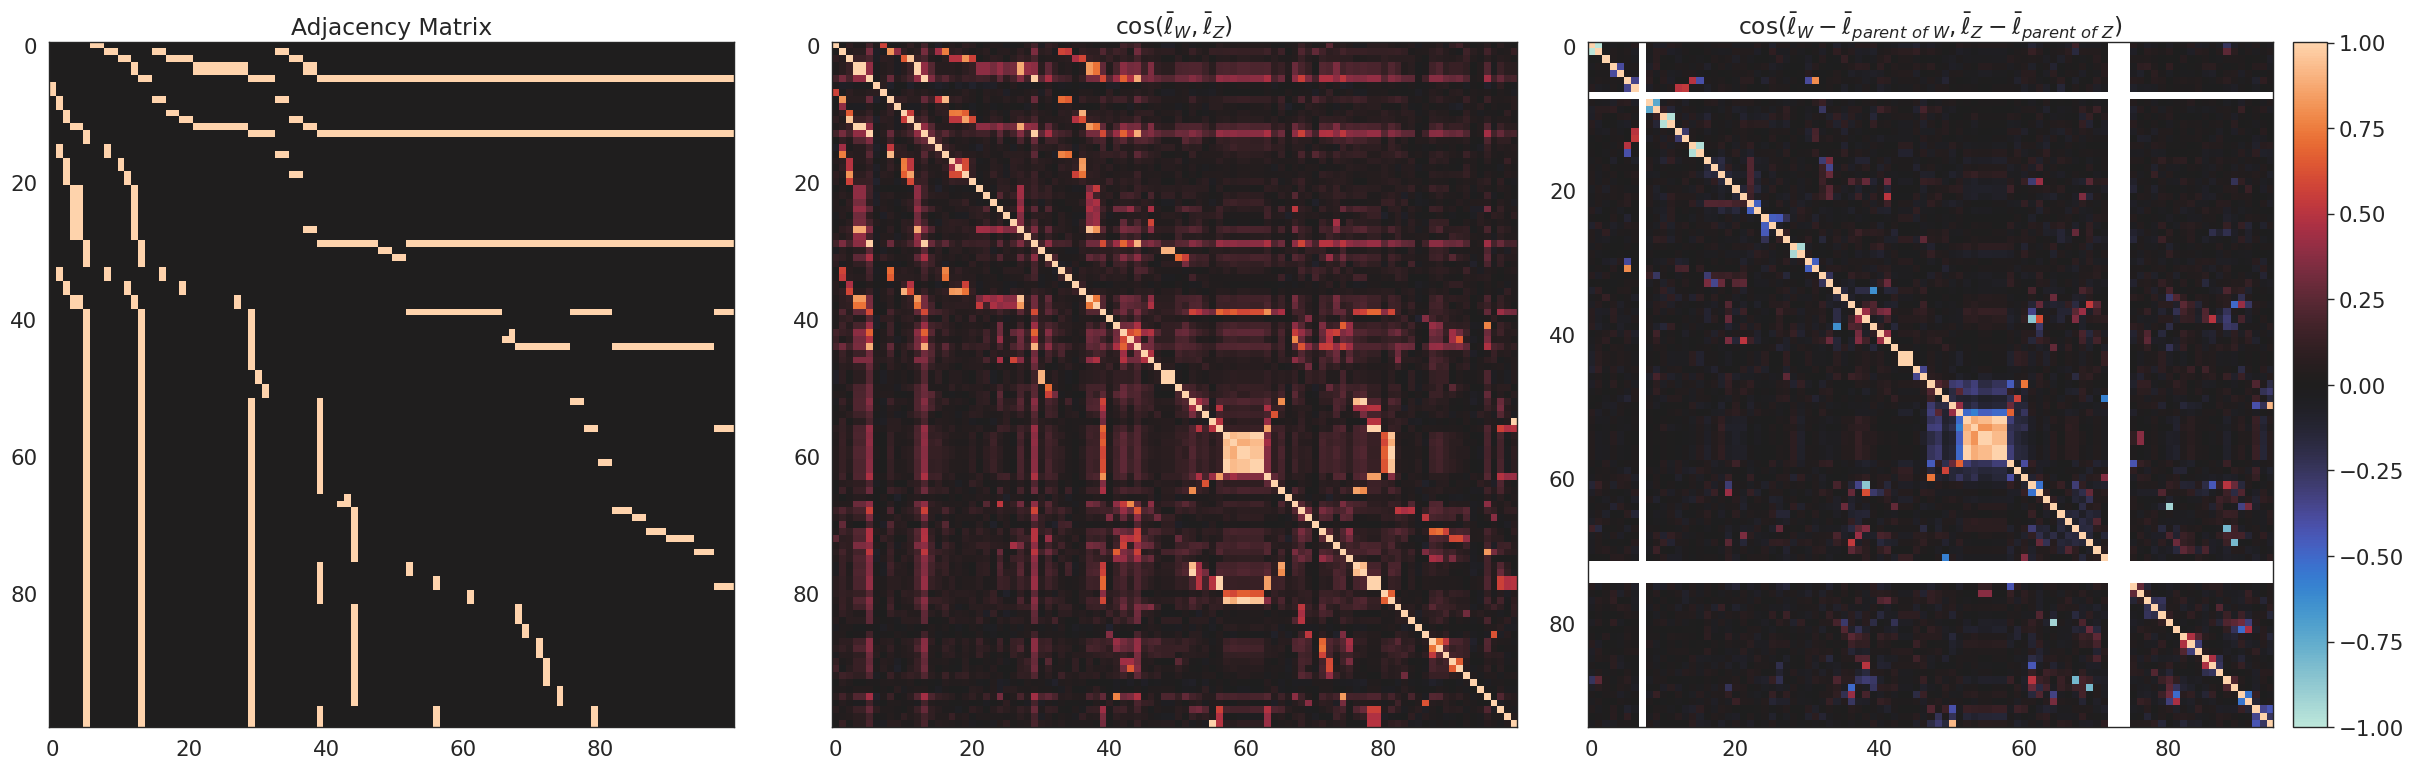

(100, 100)
(100, 100)
(95, 95)


In [5]:
parameter_model = "70M"
step = "step13000"

ontology_path = "owl/cl.owl"


save_ontology_hypernym(parameter_model, step, ontology_path)
mats = get_ontology_mats(parameter_model, step)
for mat in mats:
    print(mat.shape)